# Optimización de Parámetros - XGB

In [1]:
## Get current work directory to load all the custom modules
from pathlib import Path
import os
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent.parent.parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [2]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'autos')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/autos


In [3]:
import pandas as pd


In [4]:
import optuna
import datetime

In [5]:
from modulos.arima.gruas.general import format_timeseries, show_results_r2, arima_forecasting, total_forecasting, show_optimizer_results
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

from modulos.LR.gruas.generals import make_lags
from modulos.DirRec.gruas.optimizer import XGBOptimizer

In [6]:
data = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
data.head()

,Periodo,idArticulo,ventas,DescProducto
0,2021-05-01,9950,37.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GALO...
1,2021-04-01,9950,19.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GALO...
2,2021-03-01,9950,9.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GALO...
3,2021-02-01,9950,8.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GALO...
4,2021-01-01,9950,76.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GALO...


In [7]:
# Pivotando las tablas y llenando de ceros las ventas que no existen.
df_time = format_timeseries(data)
df_time.tail()

idArticulo,551,594,1208,1224,1627,3745,3882,3883,4070,4827,...,20301,20305,20309,20310,20697,20769,21577,23900,26158,26170
Periodo,,,,,,,,,,,,,,,,,,,,,
2021-01-01,6.0,3.0,170.0,2.0,10.0,6.0,3.0,4.0,7.0,18.0,...,8.0,4.0,1.0,2.0,0.0,5.0,7.0,260.0,16.0,5.0
2021-02-01,4.0,4.0,220.0,0.0,17.0,11.0,3.0,3.0,5.0,16.0,...,4.0,1.0,1.0,11.0,2.0,1.0,11.0,16.0,5.0,18.0
2021-03-01,4.0,6.0,155.0,0.0,8.0,10.0,2.0,0.0,4.0,2.0,...,14.0,11.0,11.0,9.0,2.0,12.0,13.0,80.0,6.0,14.0
2021-04-01,8.0,8.0,155.0,6.0,25.0,24.0,3.0,9.0,0.0,1.0,...,11.0,4.0,1.0,3.0,1.0,3.0,0.0,71.0,10.0,5.0
2021-05-01,13.0,4.0,80.0,1.0,5.0,4.0,0.0,4.0,0.0,1.0,...,15.0,9.0,9.0,4.0,1.0,1.0,16.0,41.0,3.0,0.0


## Optimizando un solo Producto

## Baseline XGB

In [8]:
idArticulo = 4827
ts = df_time[idArticulo].copy()

# Lag features
n_lags = 3
X = make_lags(ts, n_lags)
# Multistep targets
y = pd.DataFrame({
    'y': ts,
})

y, X = y.align(X, join='inner', axis=0)

In [9]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [10]:
model = XGBRegressor()
scores = cross_val_score(model, X, y, cv=10, scoring='r2')
print(f"Cross validation results r2: {scores.mean()} ")
model.fit(X, y)

Cross validation results r2: -0.8912271391582985 


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [11]:
y_fit = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)
#y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

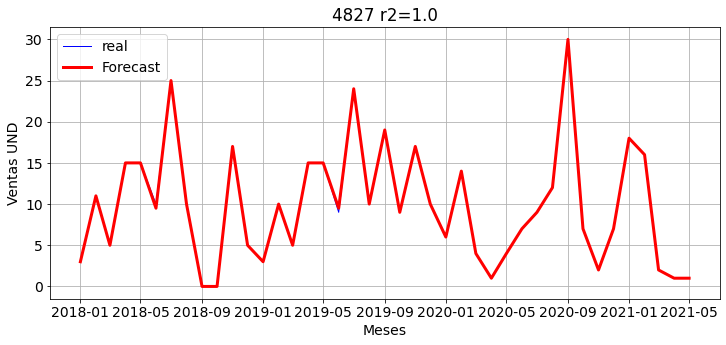

0.9997598008441122

In [12]:
show_results_r2(df_time, y_fit, idArticulo)


# Optimizar todos los Productos        
        

In [13]:
optimizer = XGBOptimizer(df_time, iterations=80, data_path= DATA_PATH , model='XGB', subpath = 'DirRec')
optimizer.run( chunk_size=4)

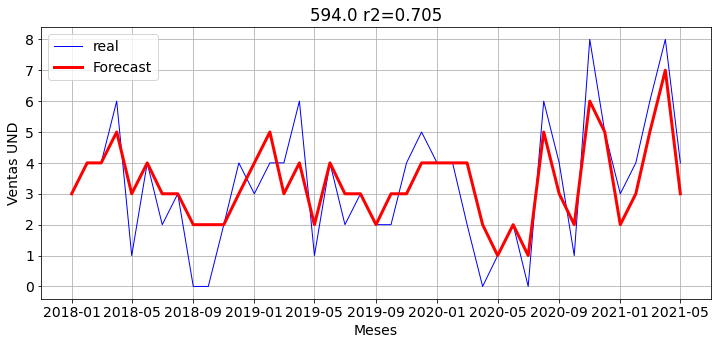

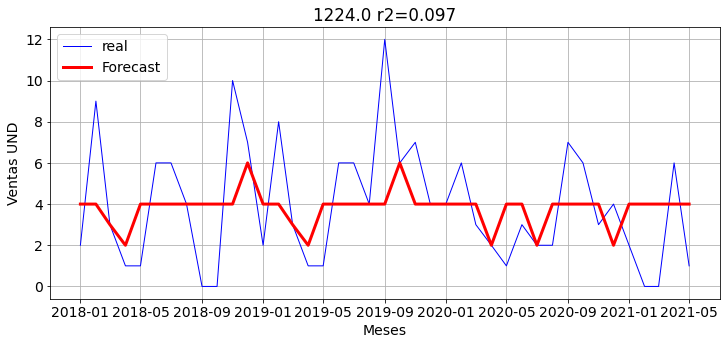

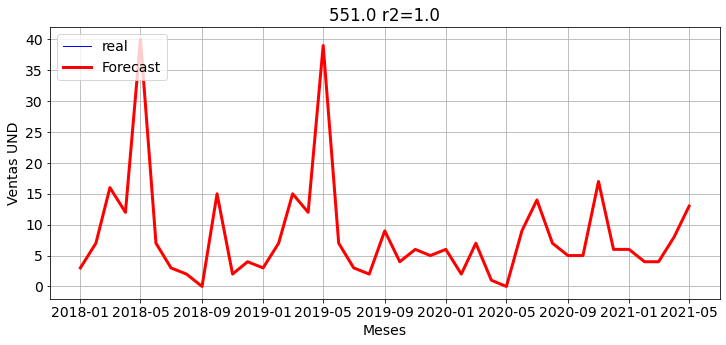

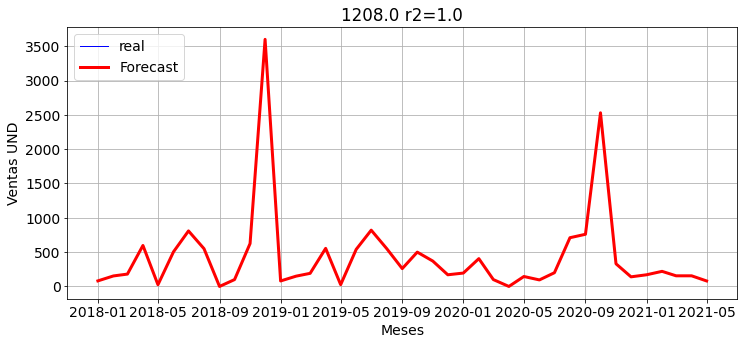

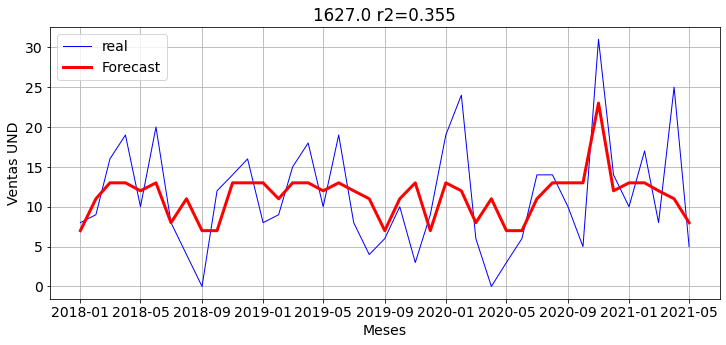

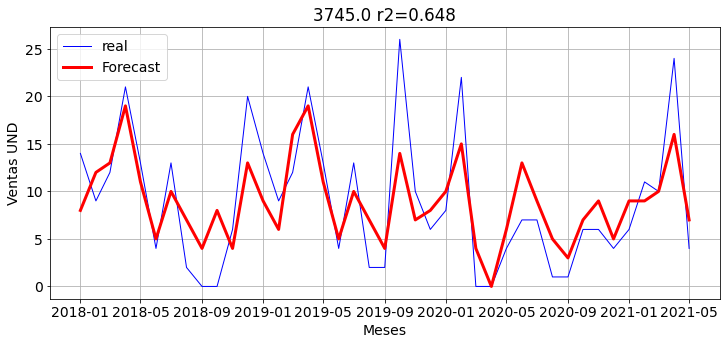

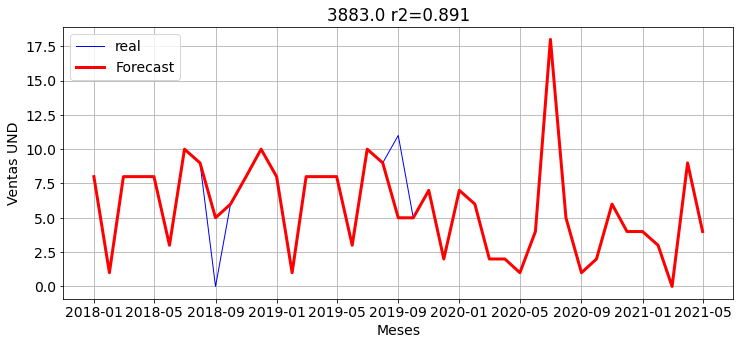

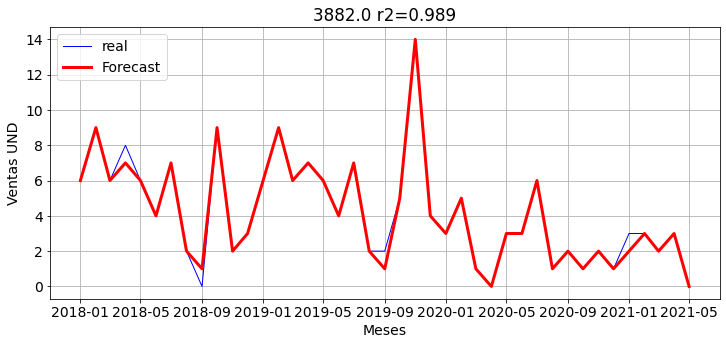

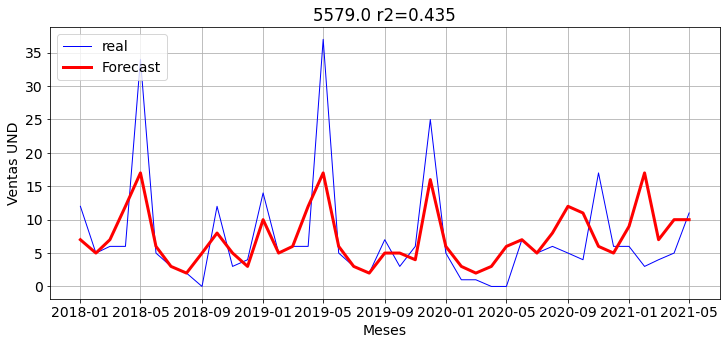

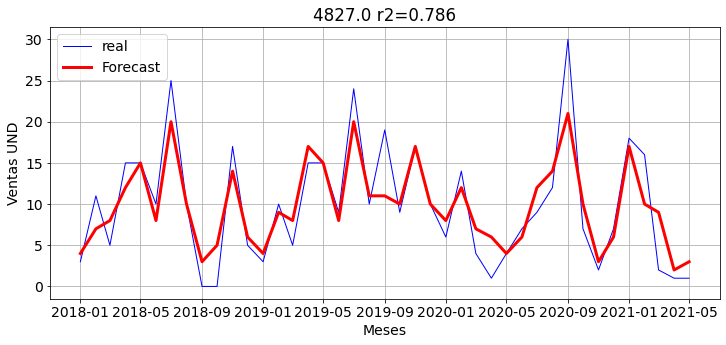

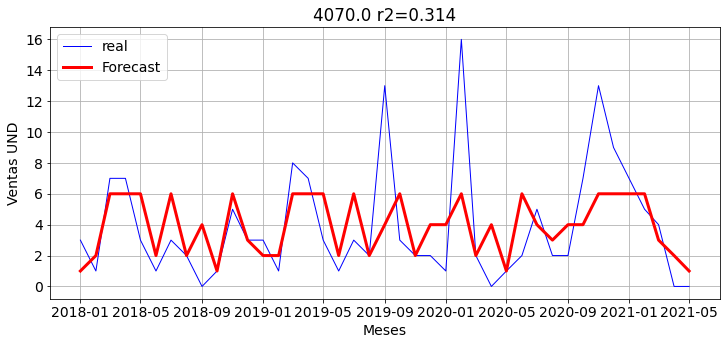

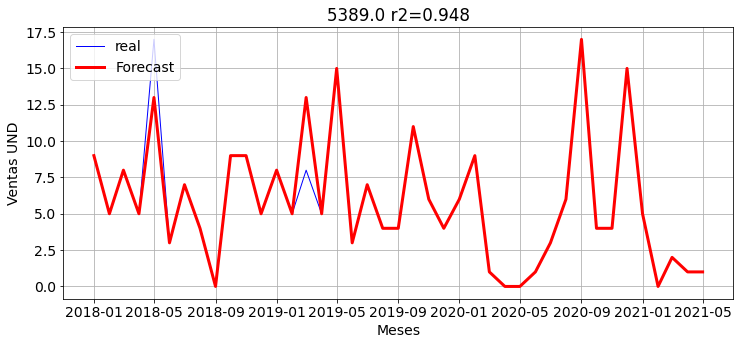

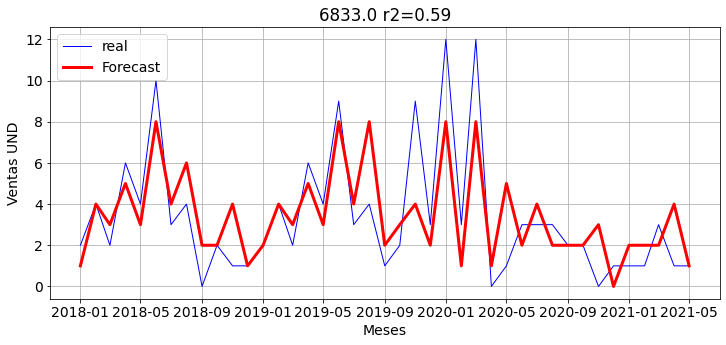

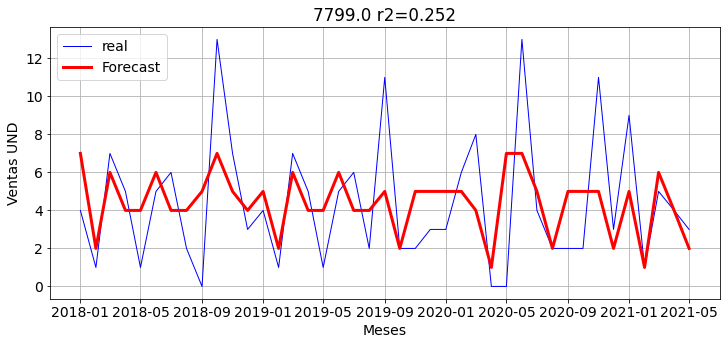

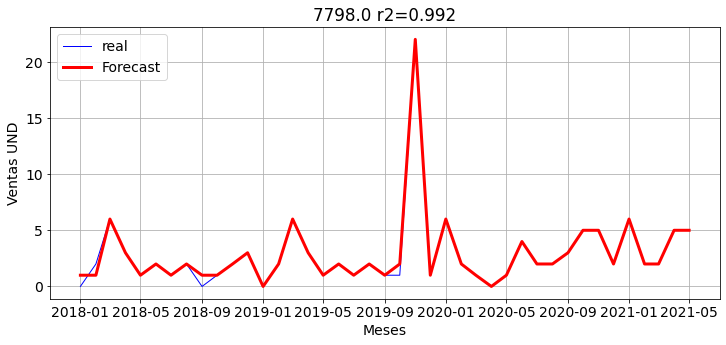

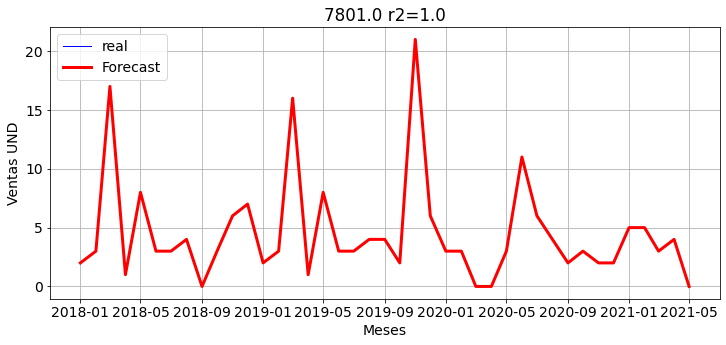

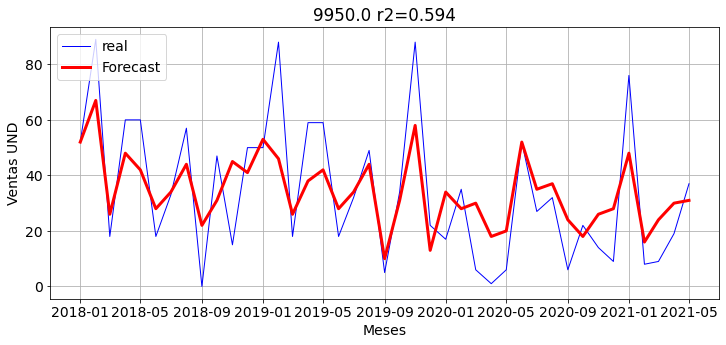

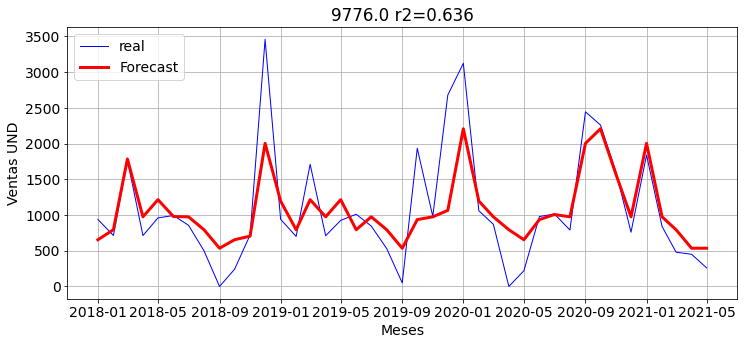

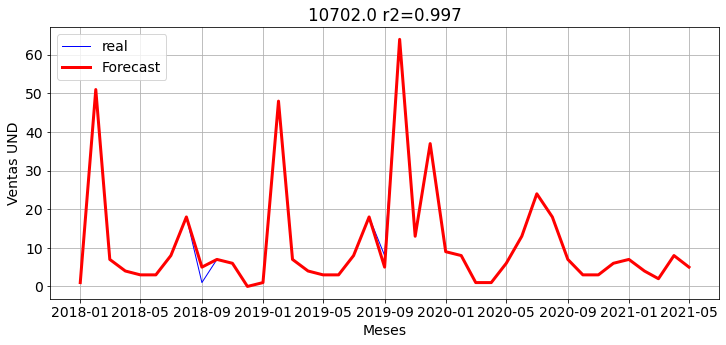

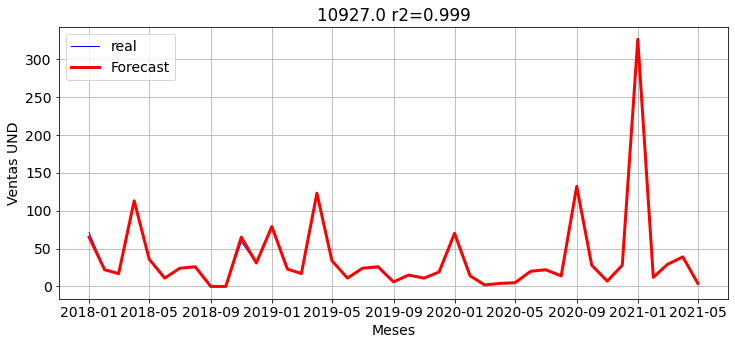

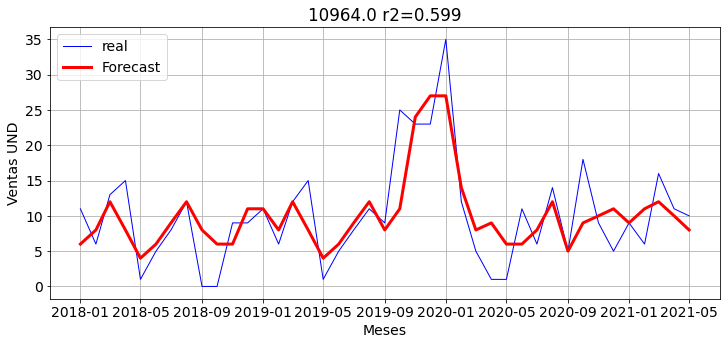

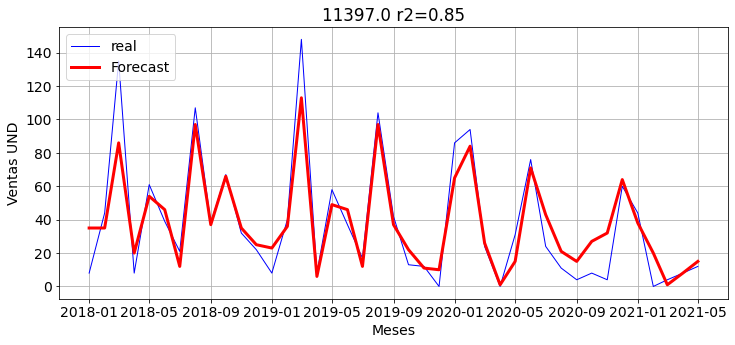

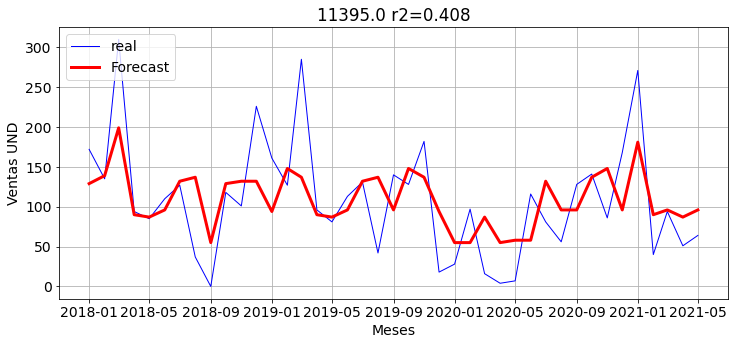

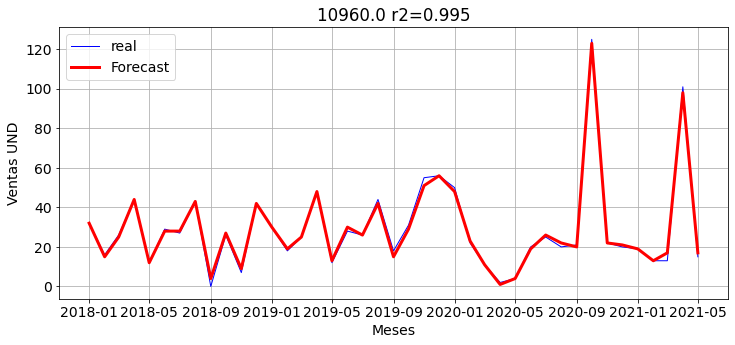

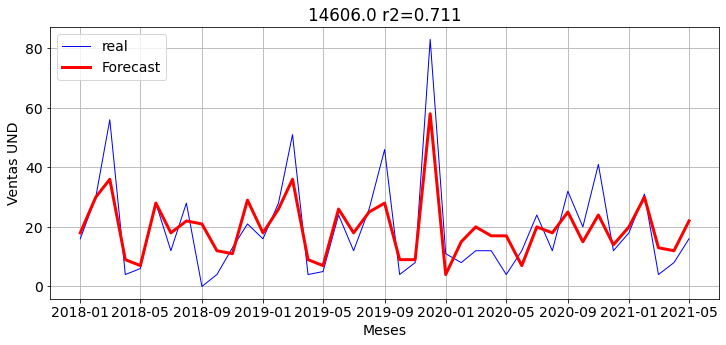

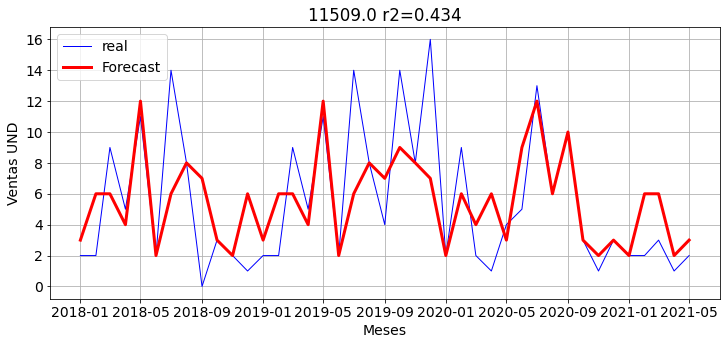

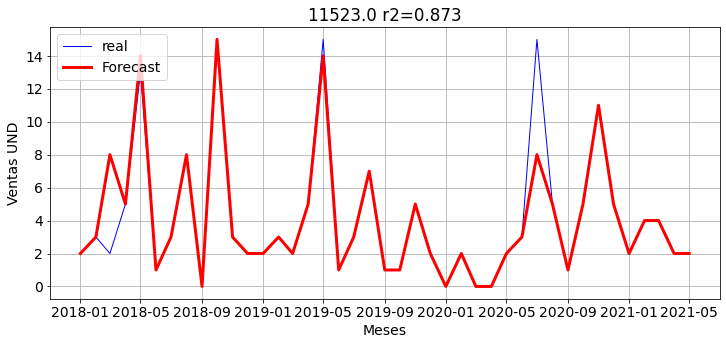

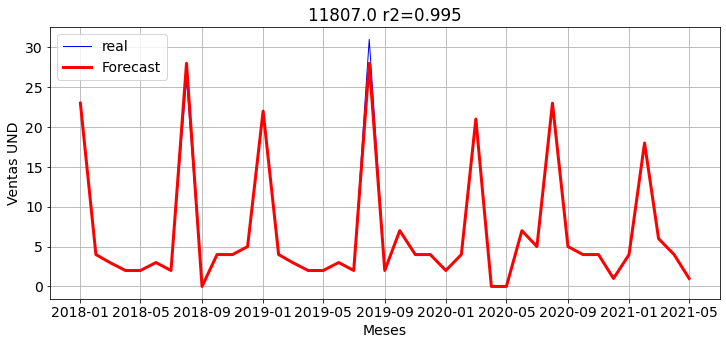

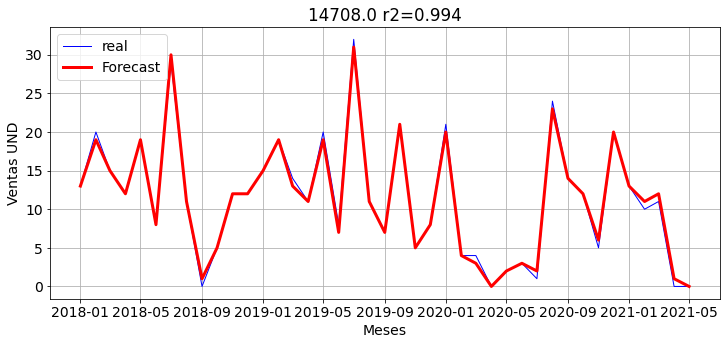

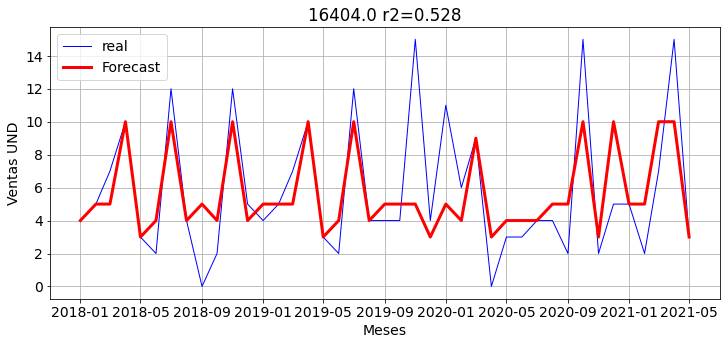

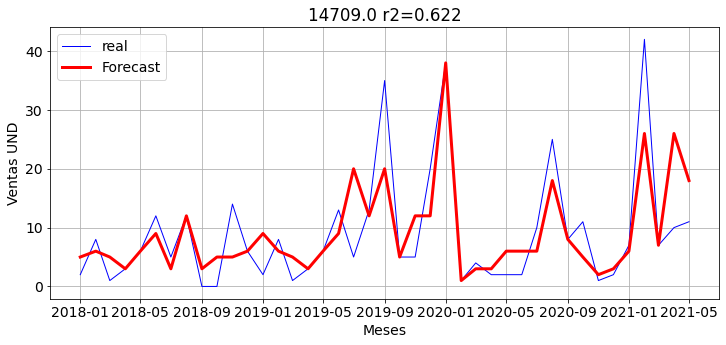

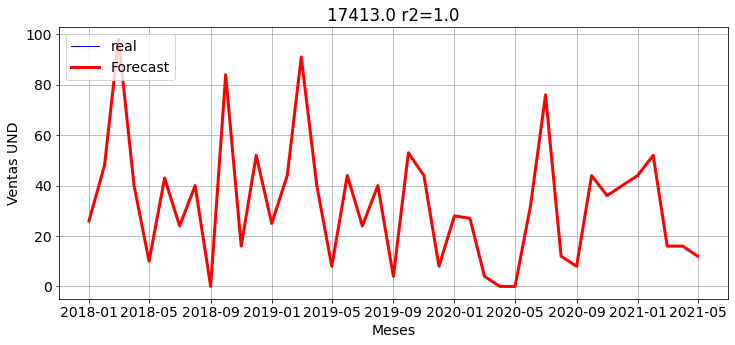

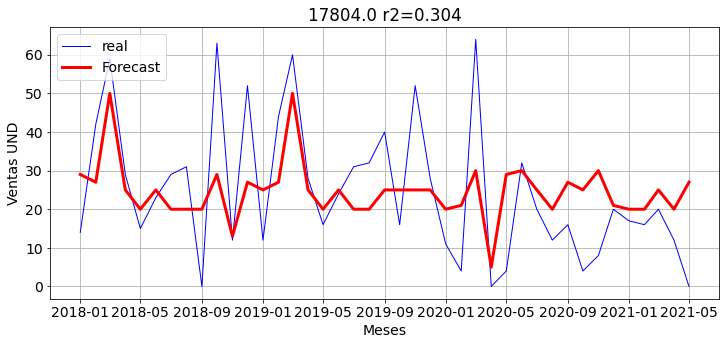

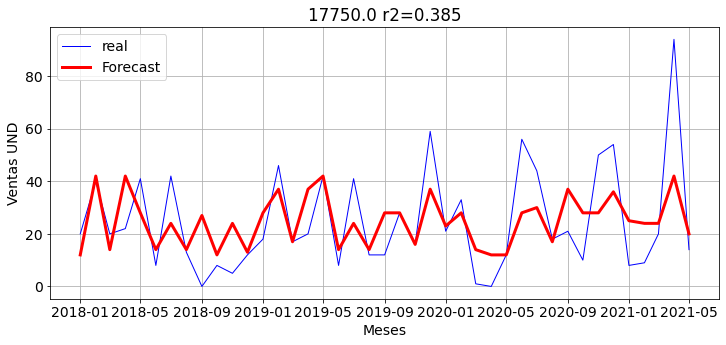

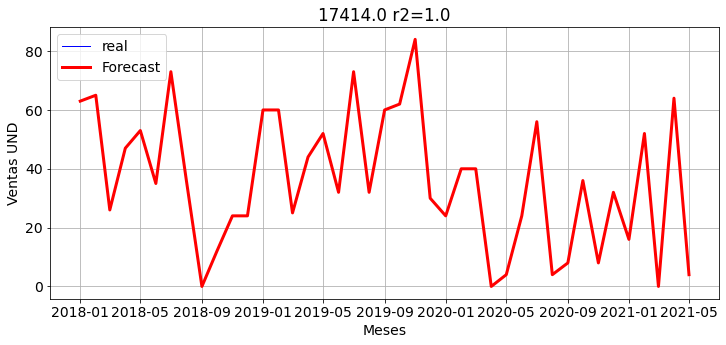

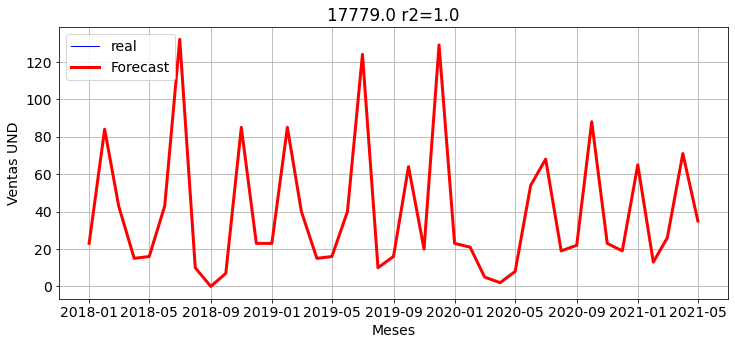

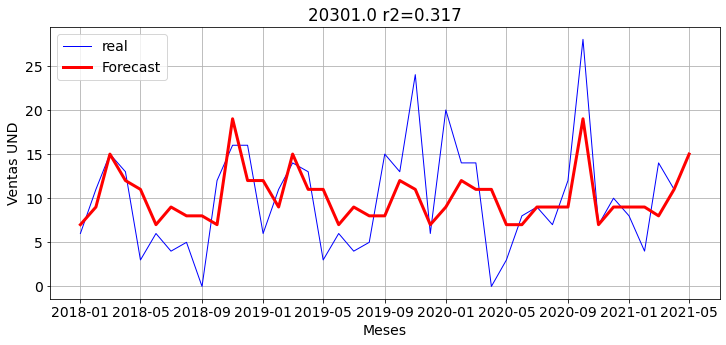

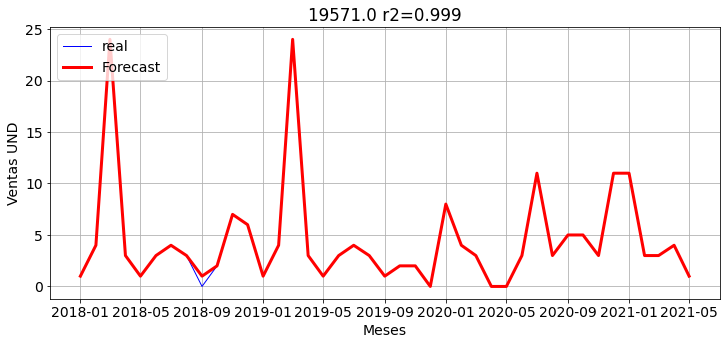

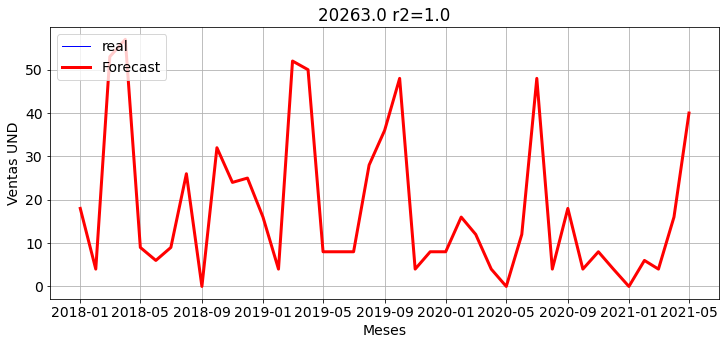

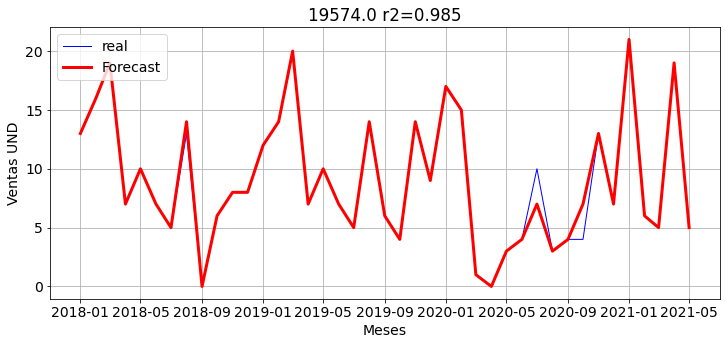

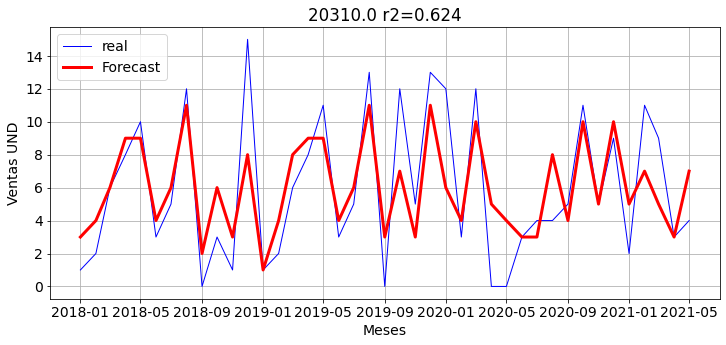

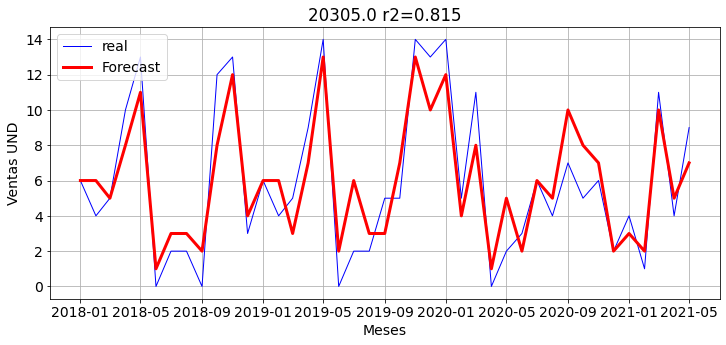

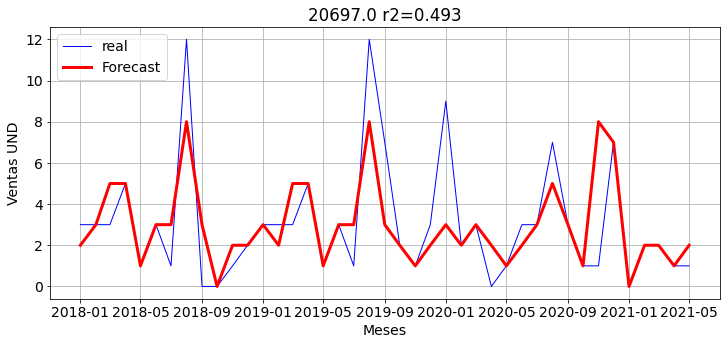

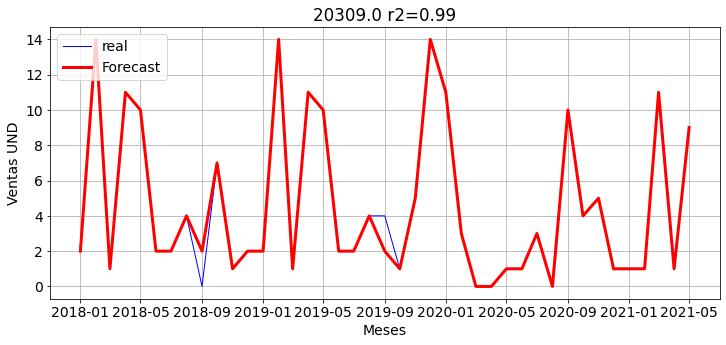

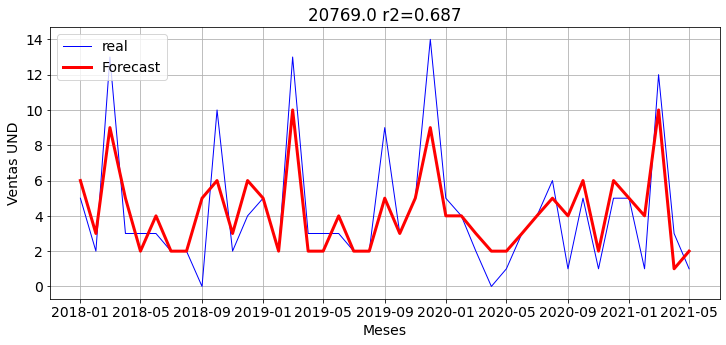

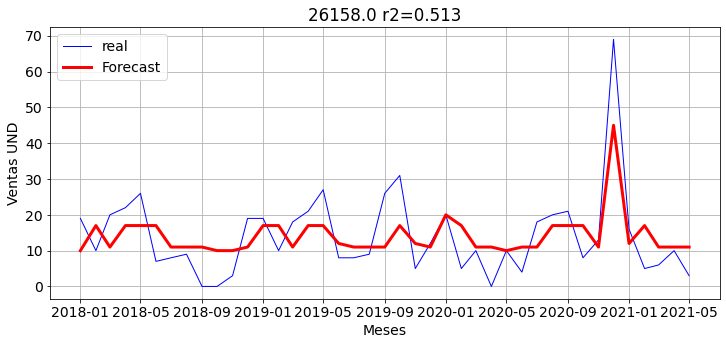

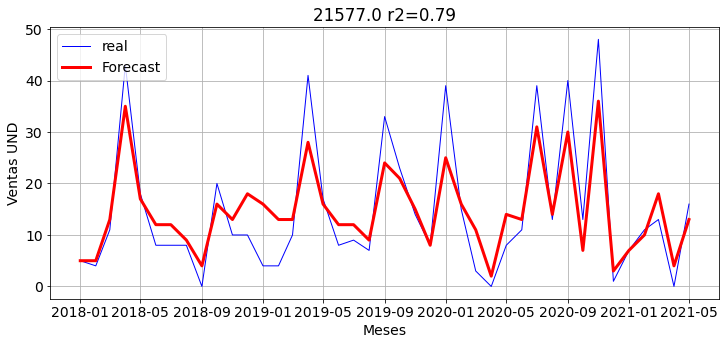

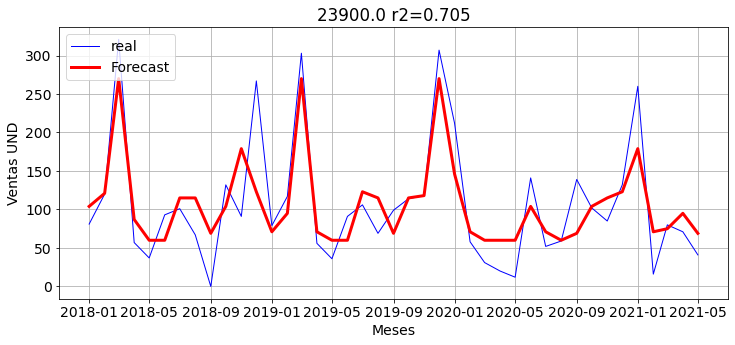

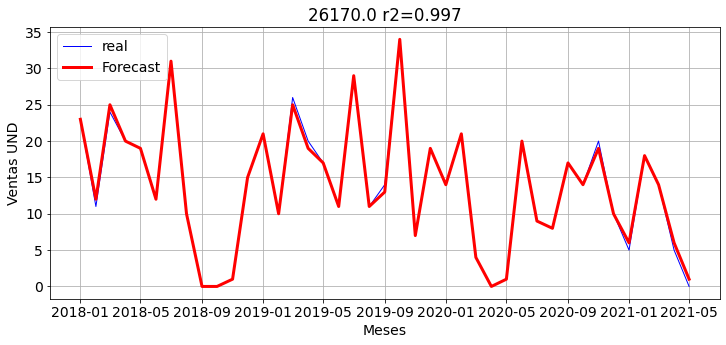

In [14]:
optimizer.print_results()

# Optimizer -  Evolution on time

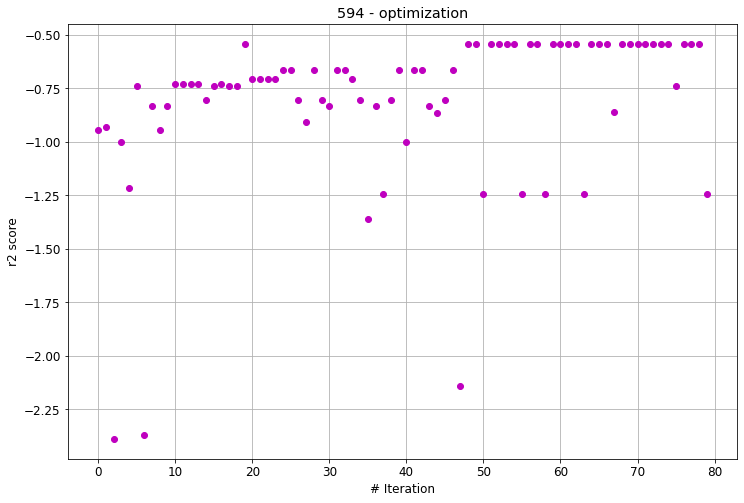

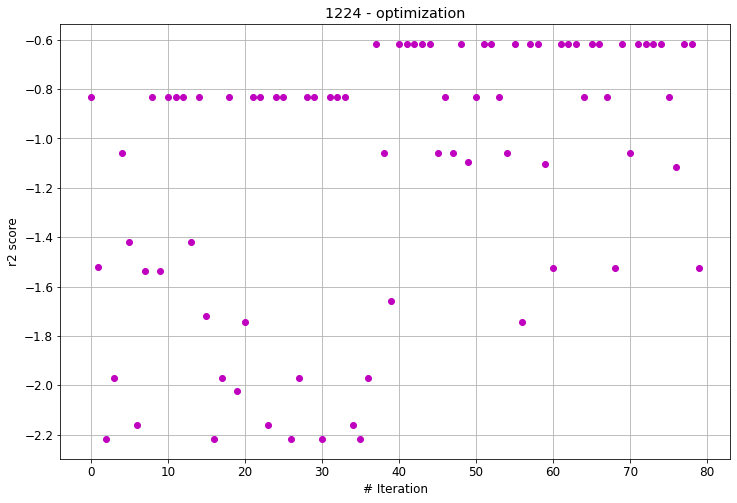

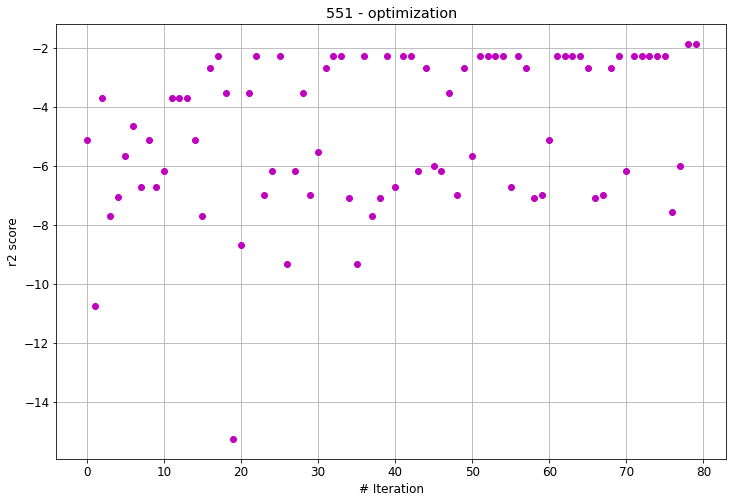

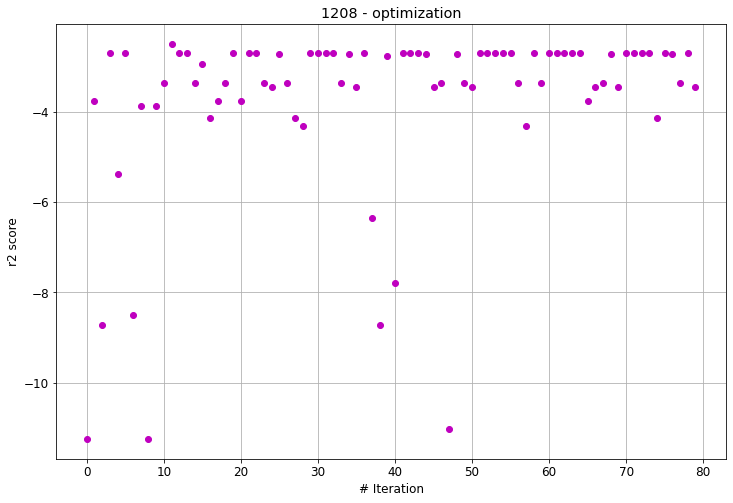

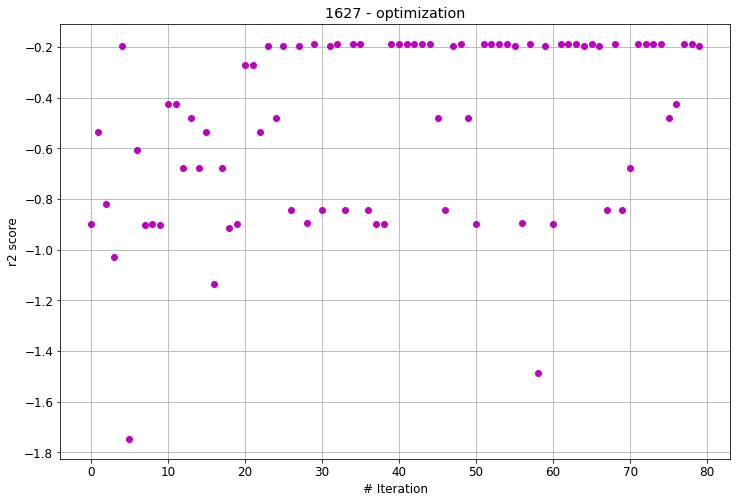

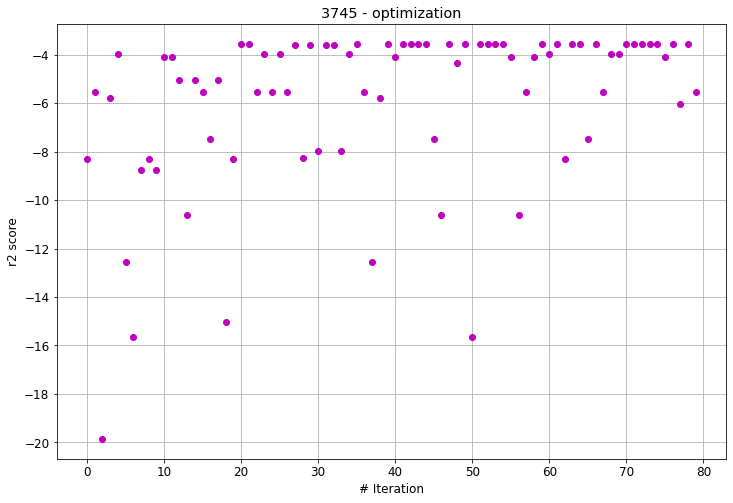

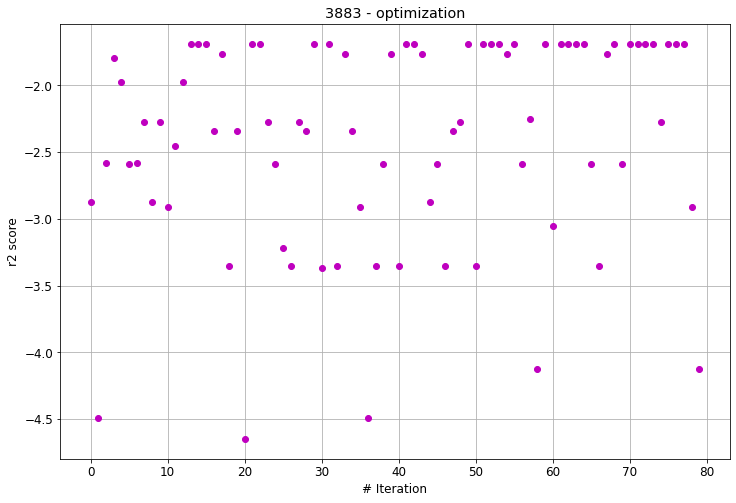

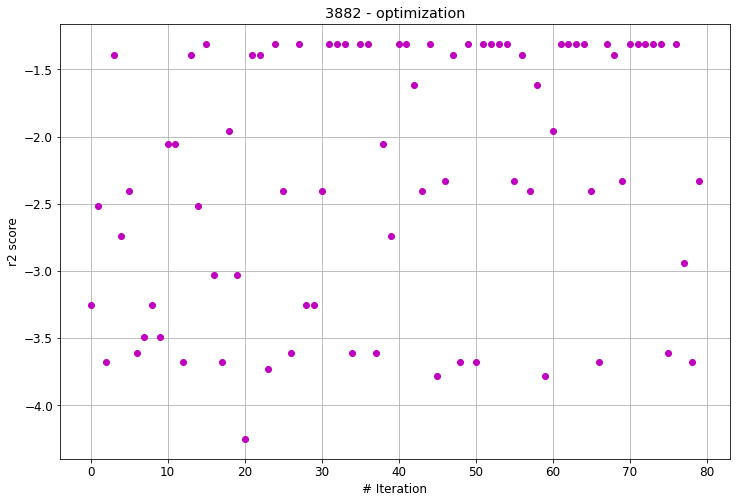

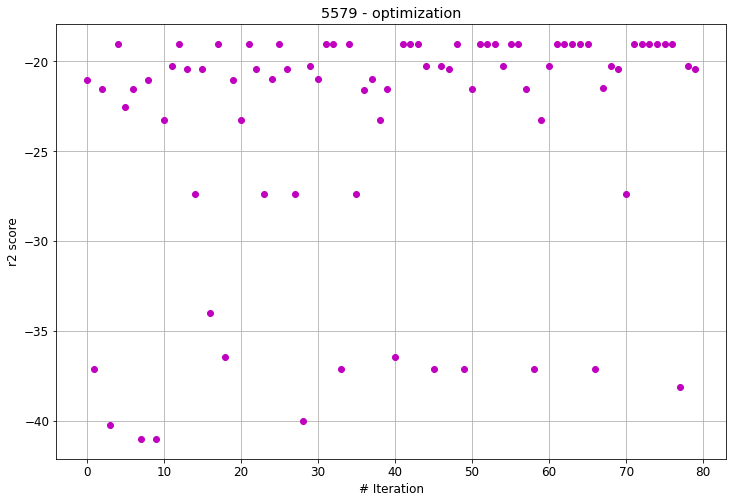

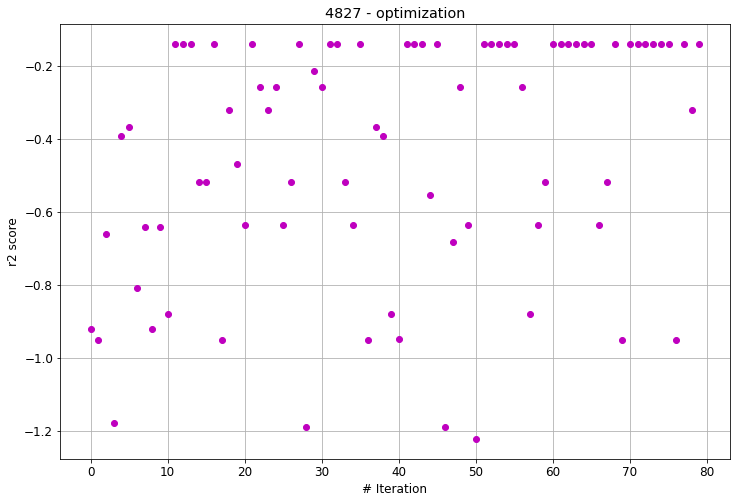

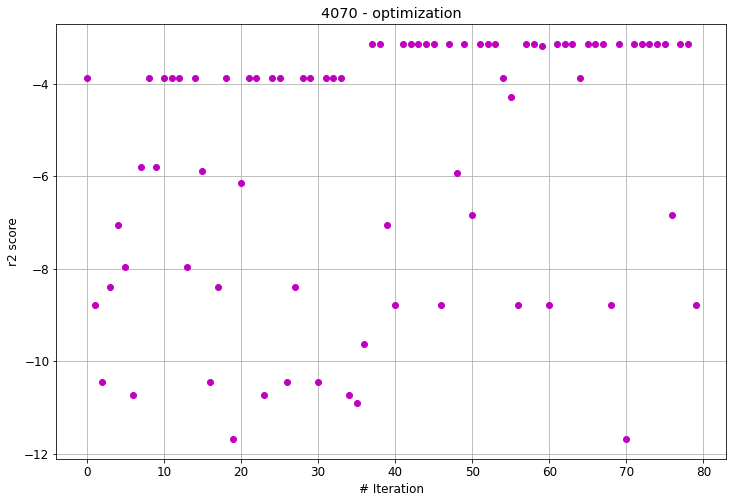

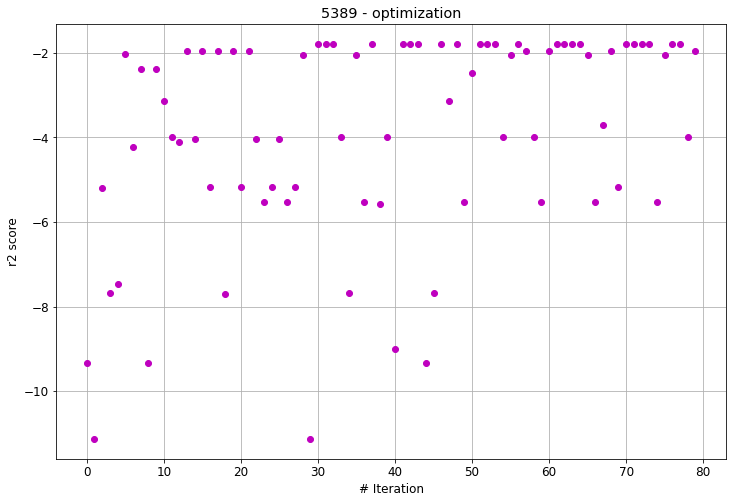

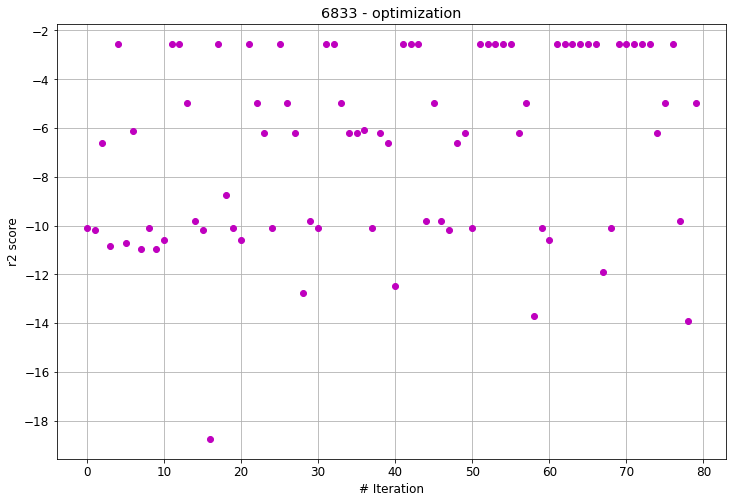

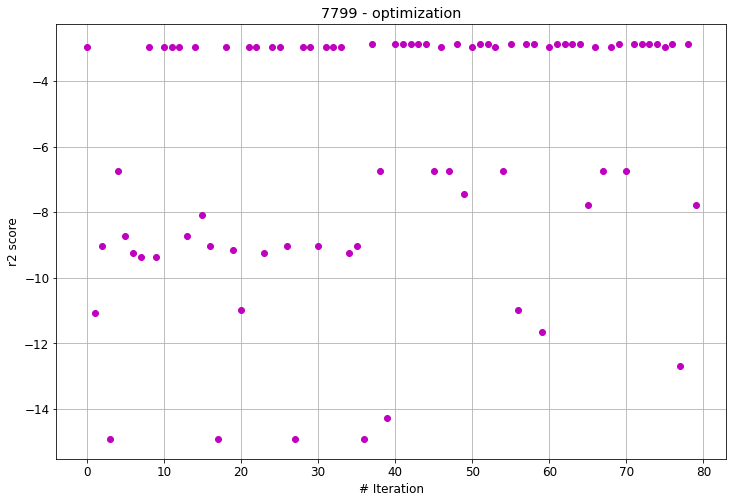

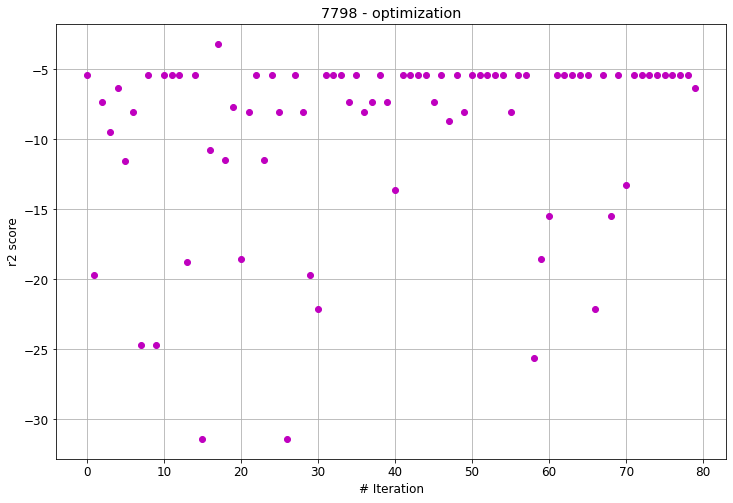

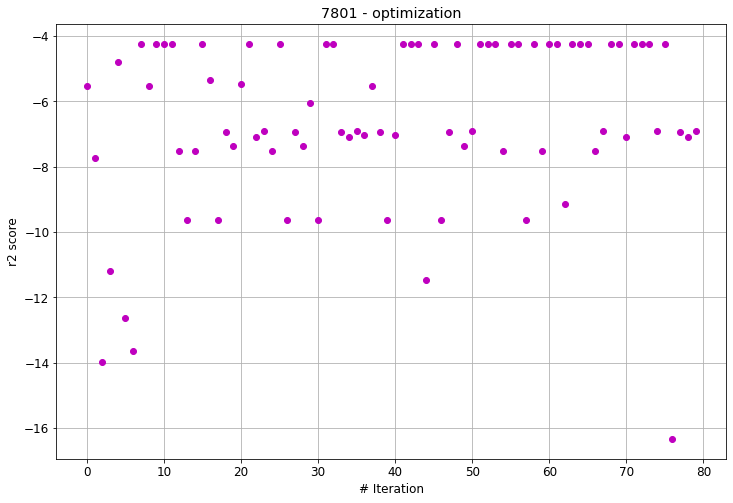

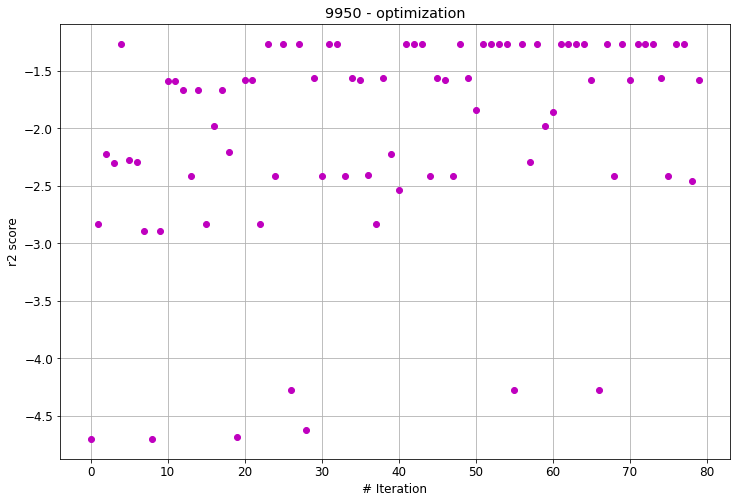

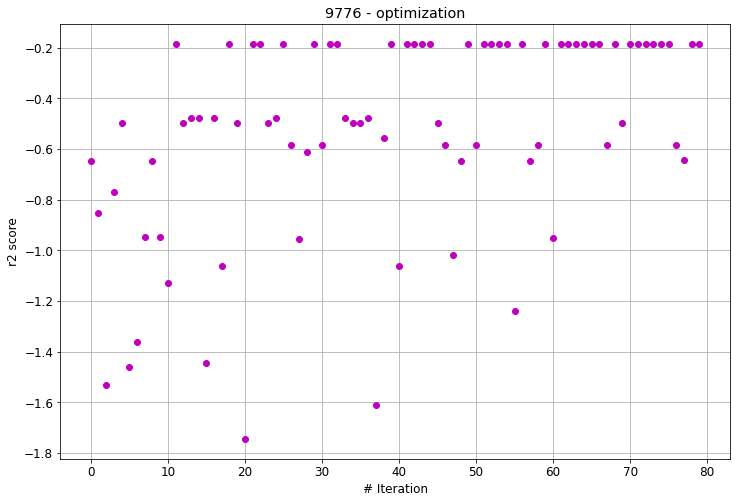

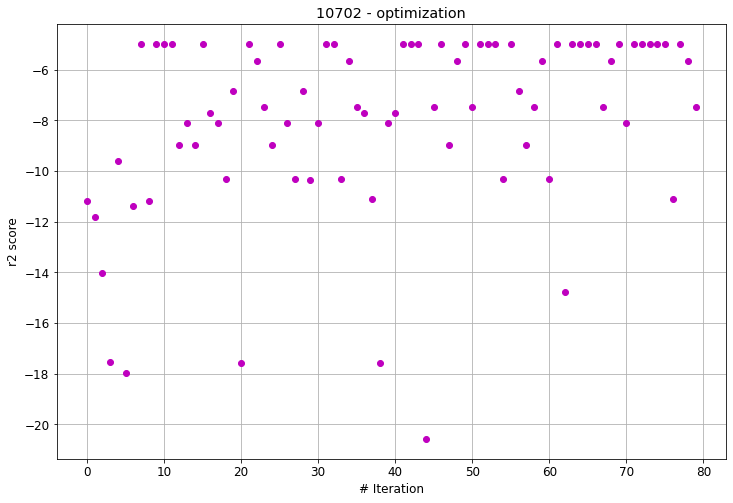

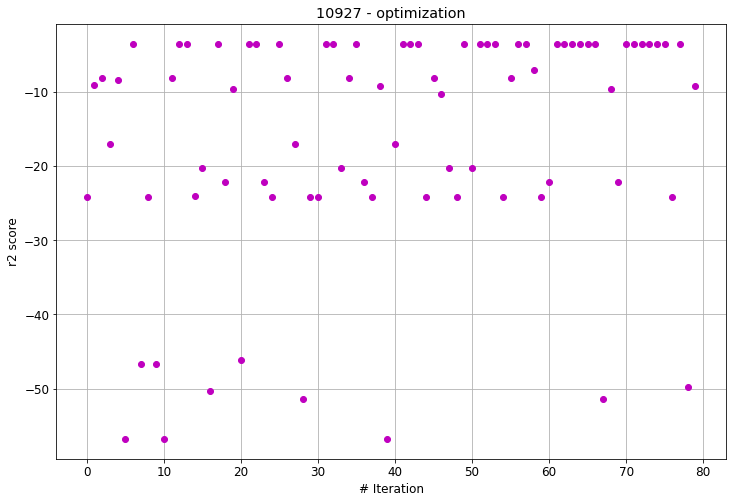

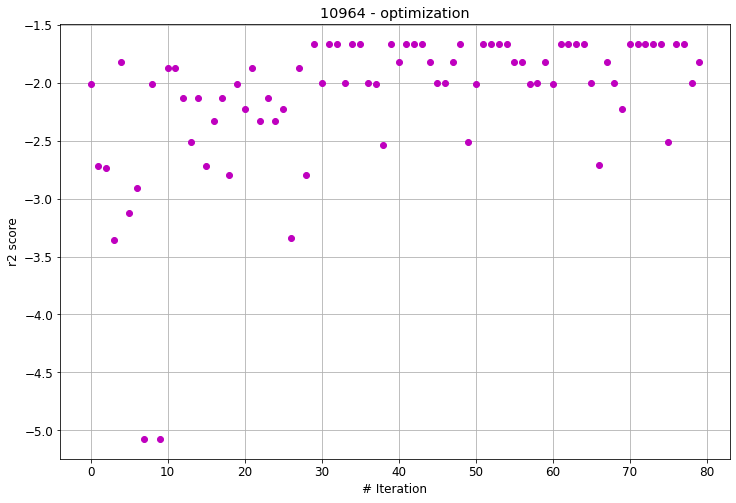

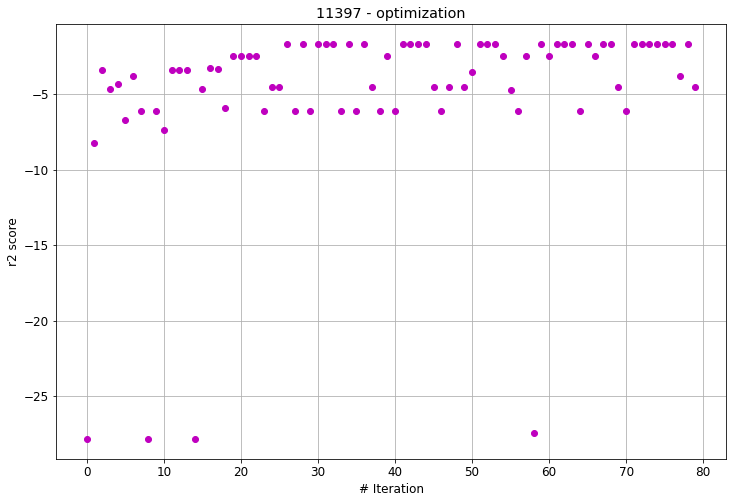

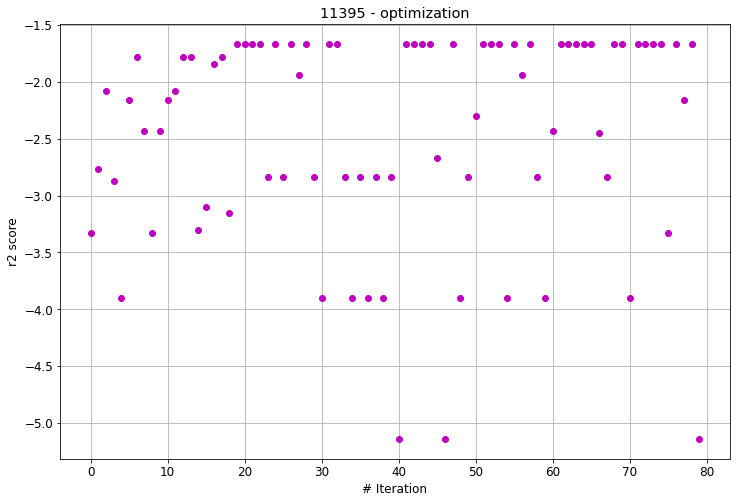

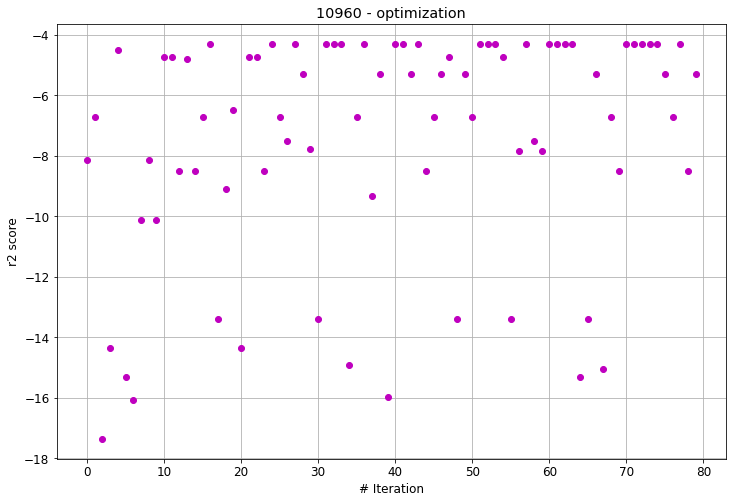

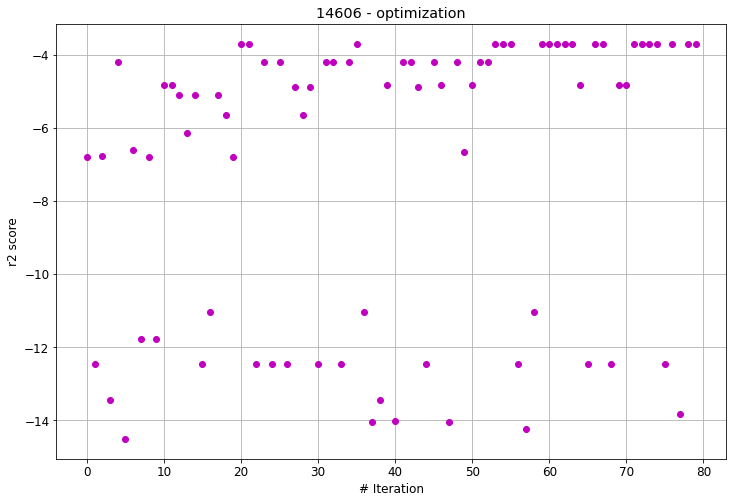

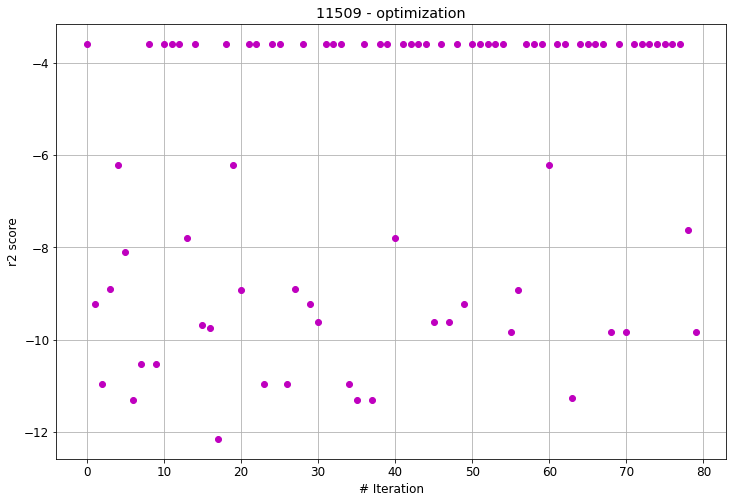

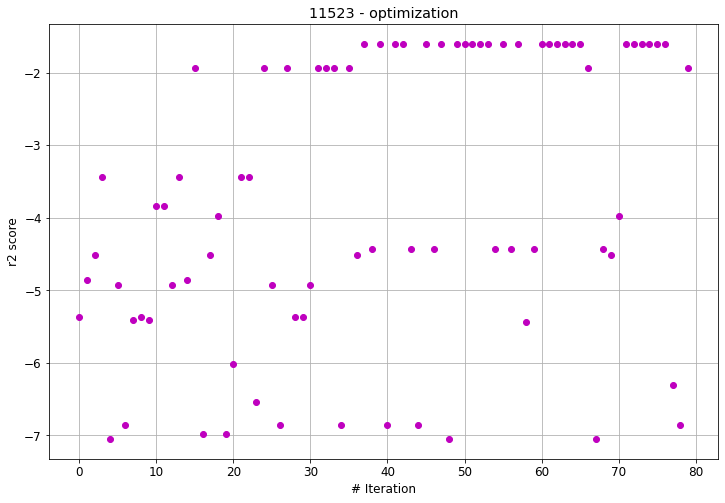

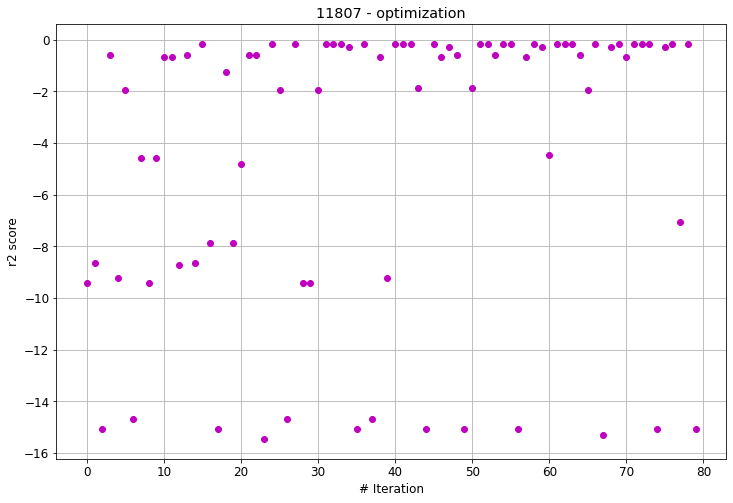

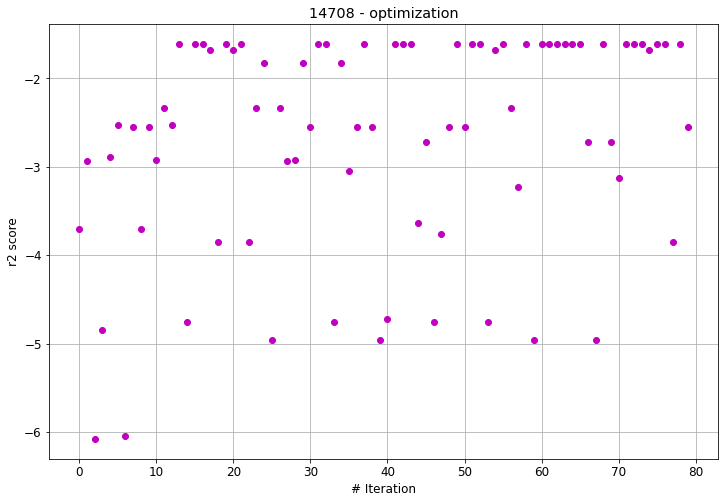

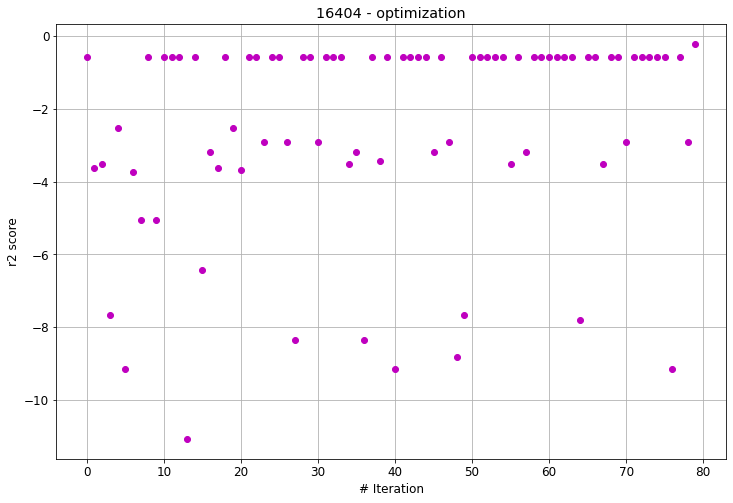

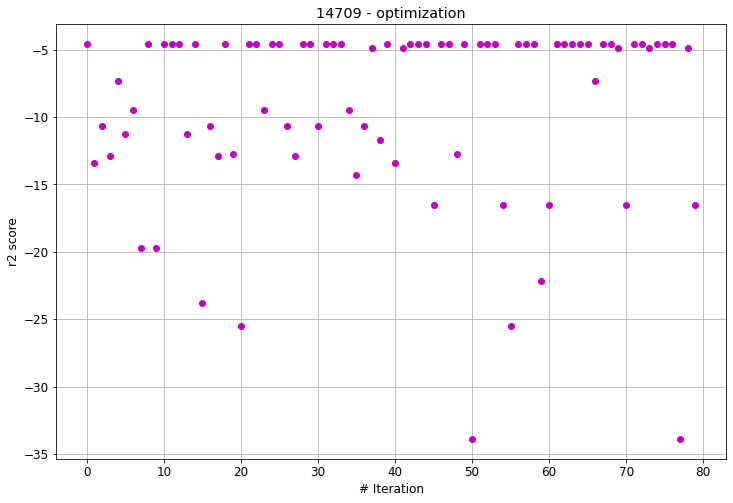

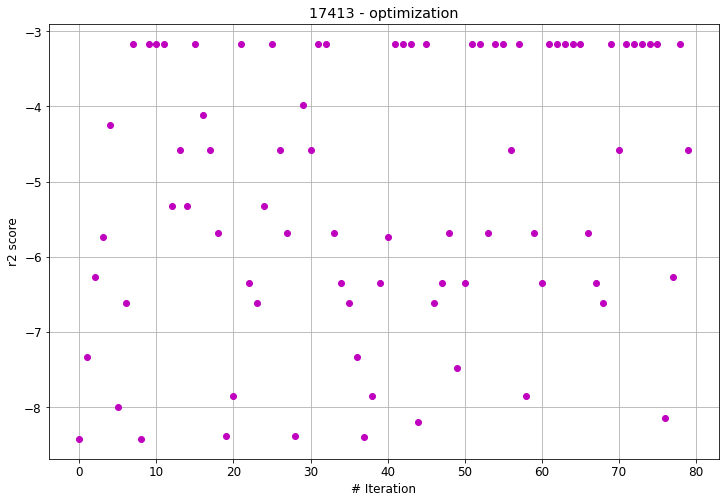

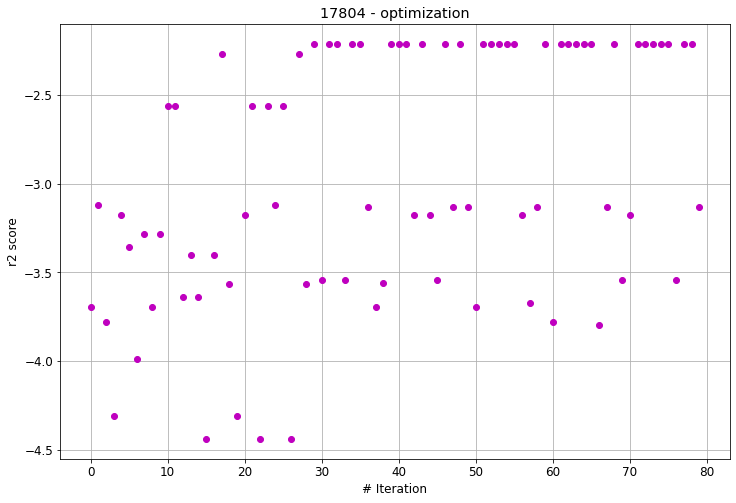

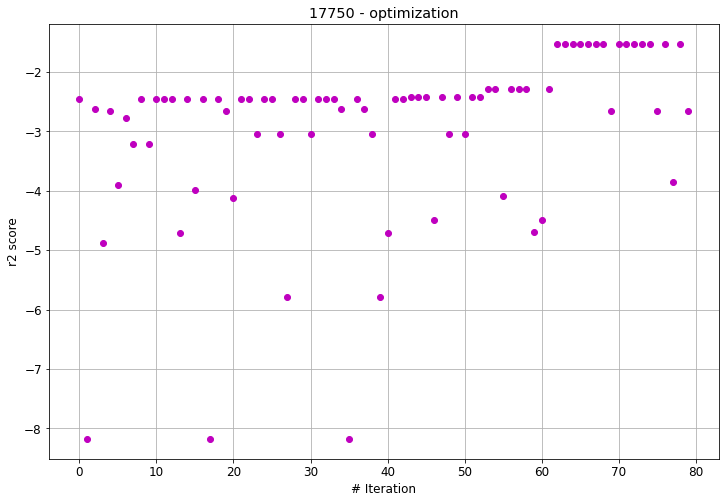

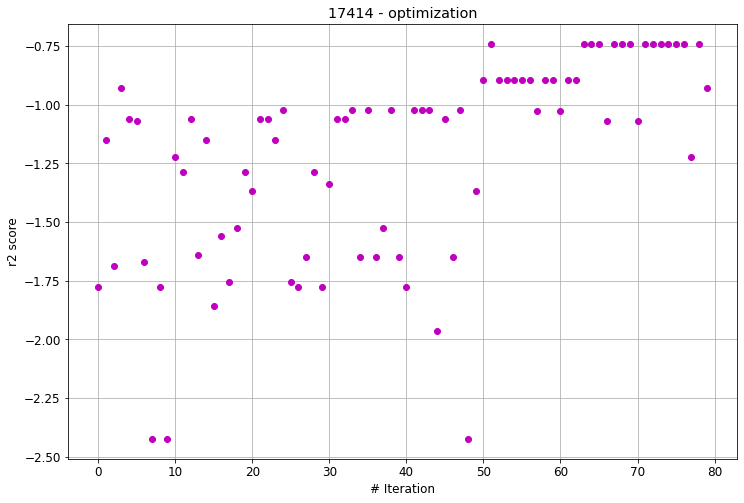

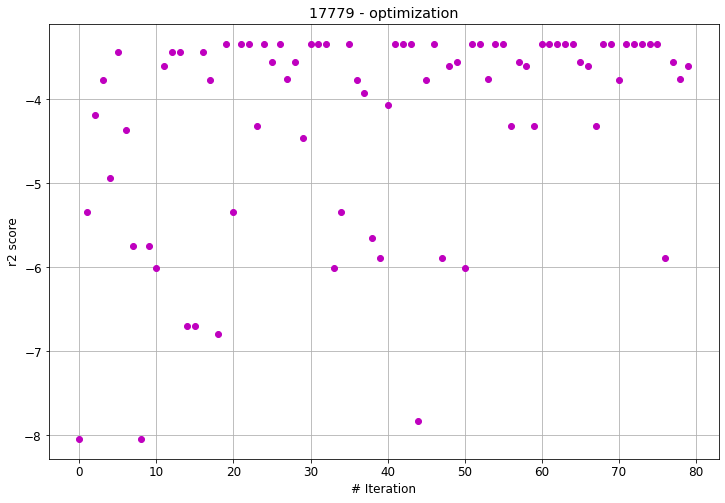

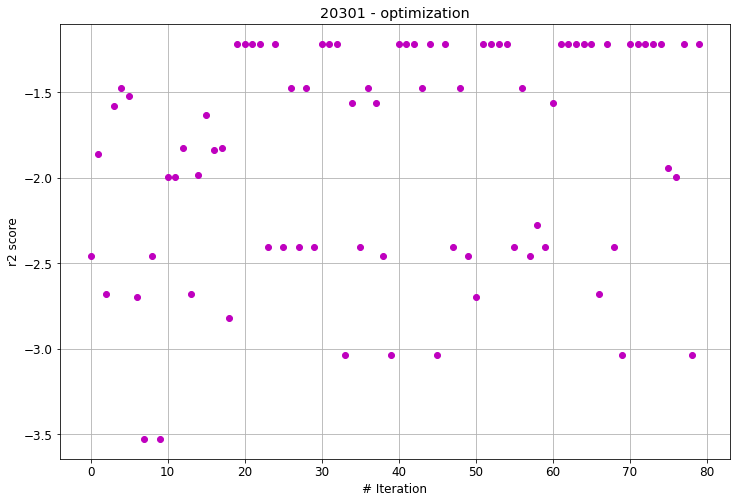

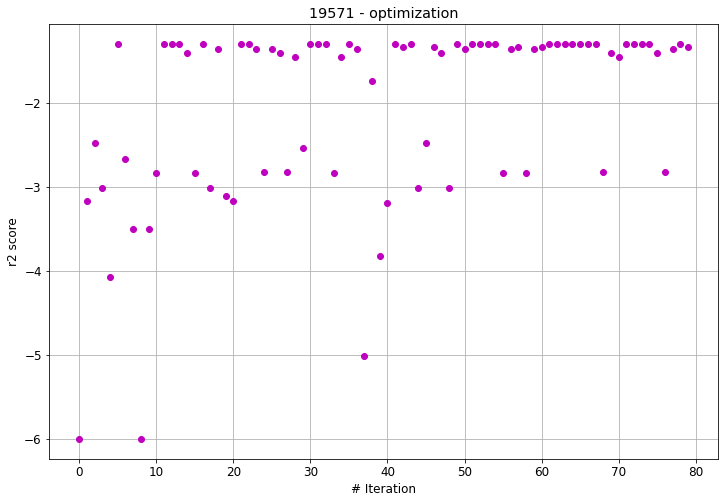

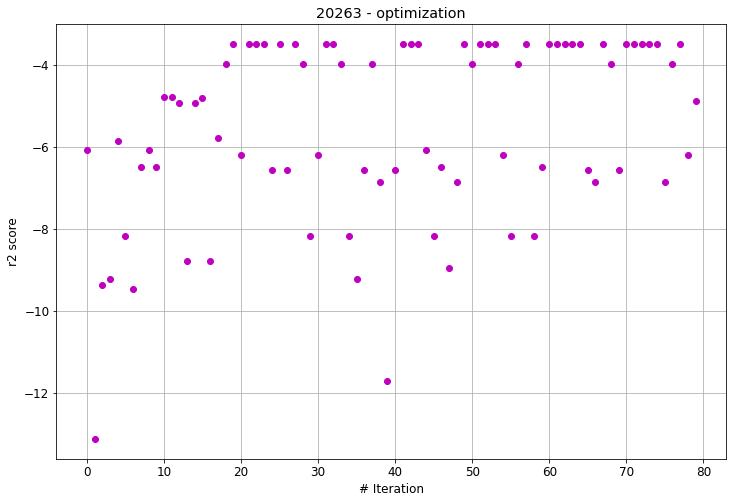

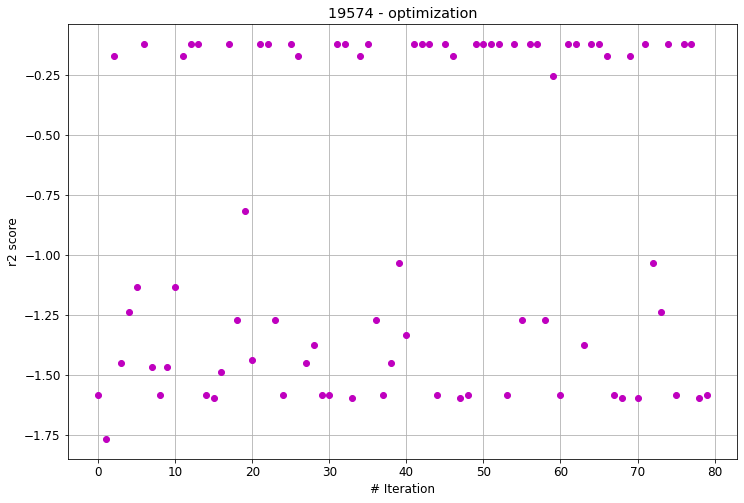

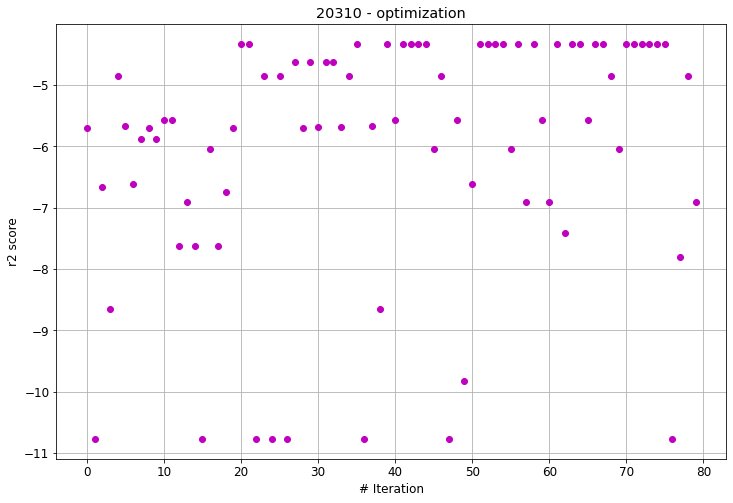

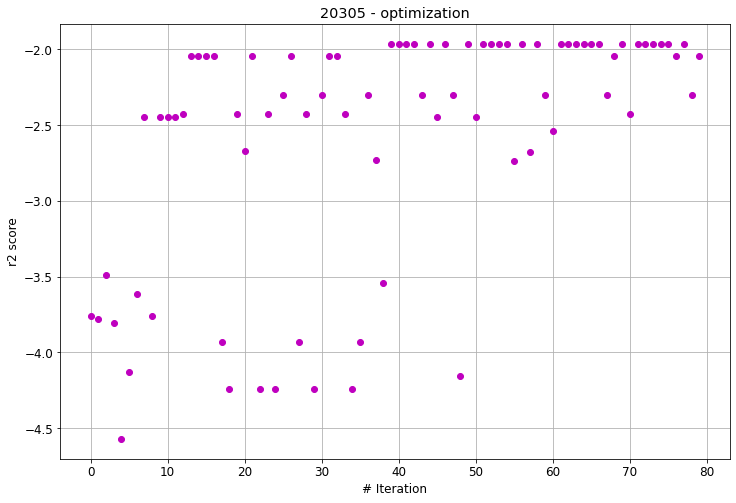

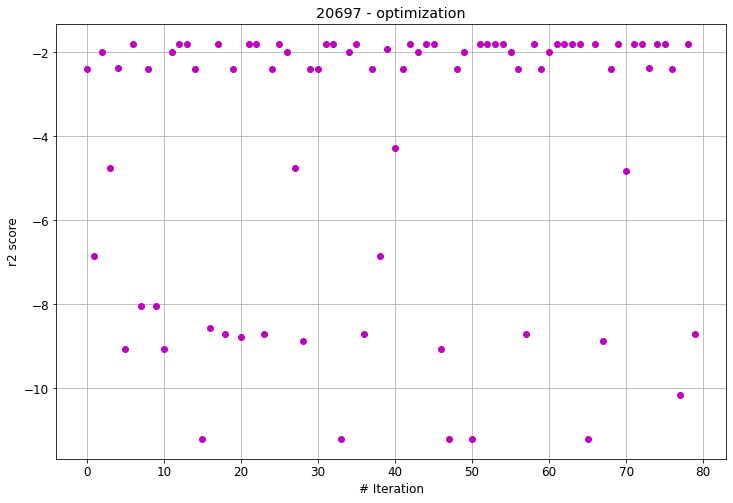

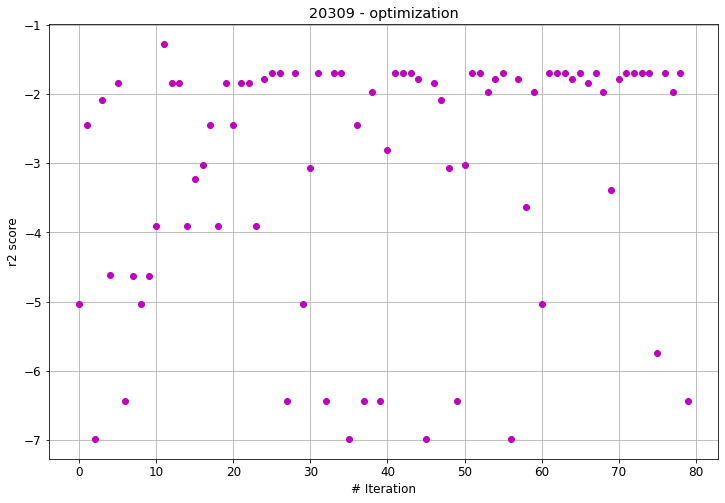

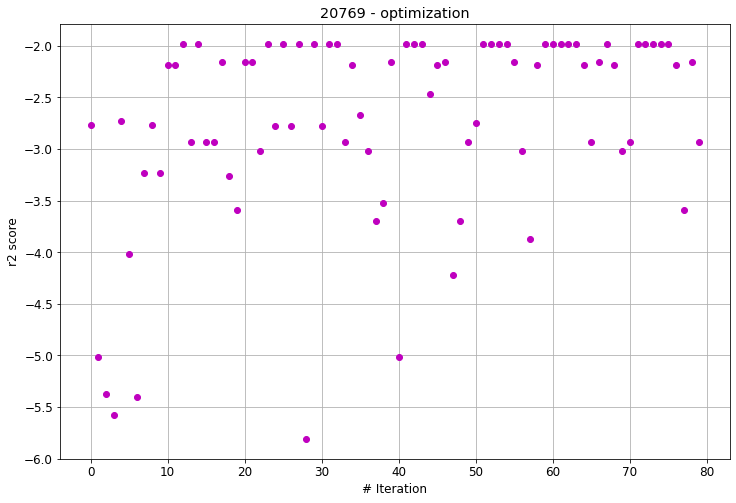

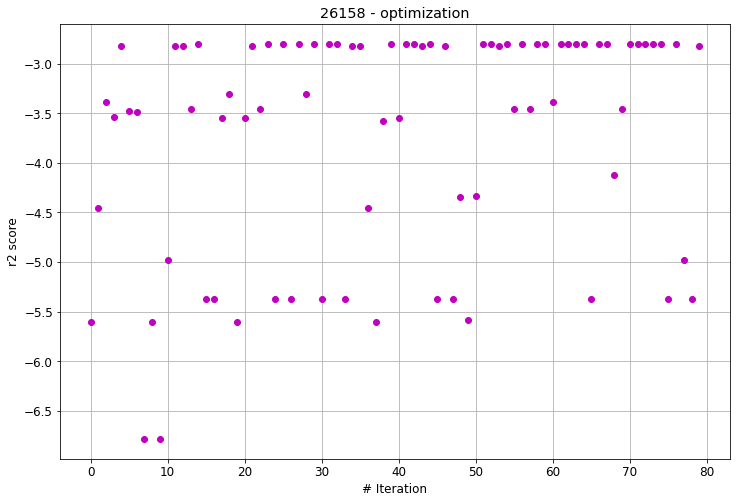

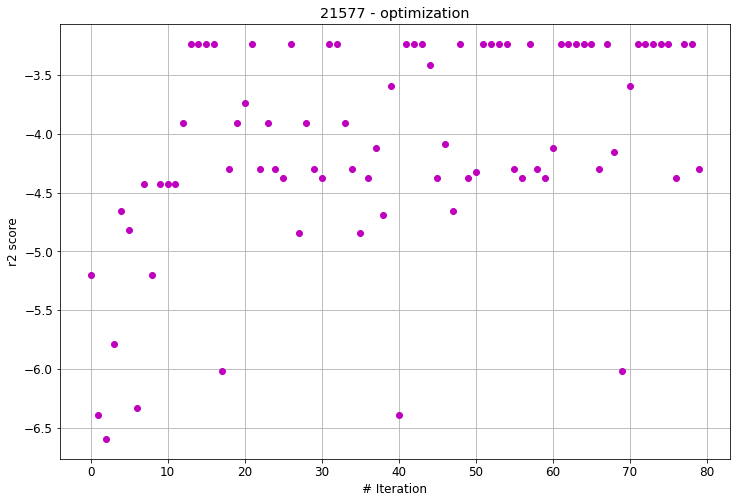

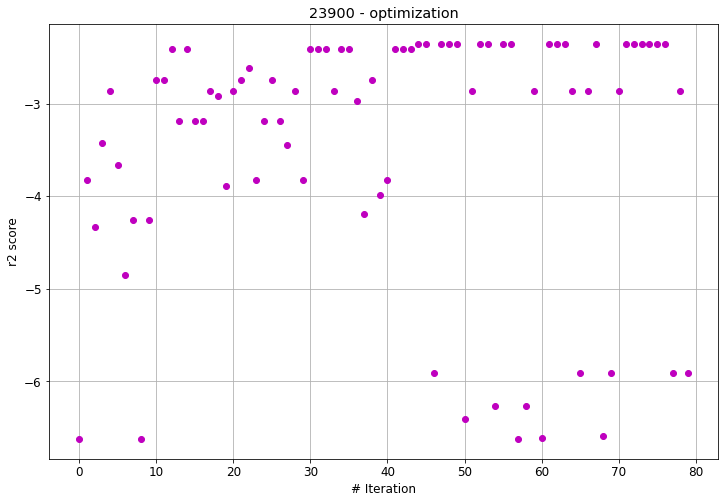

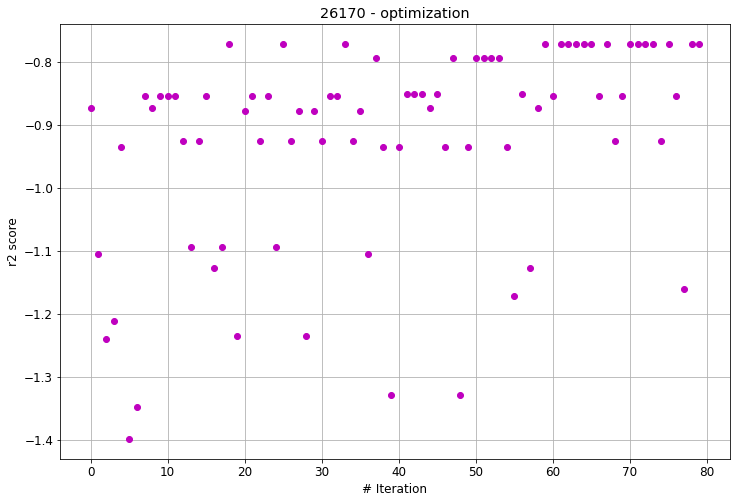

In [15]:
optimizer.print_optimizer_results()

In [16]:
optimizer.results

,idArticulo,hyper,r2,model
0,594.0,"{'n_lags': 5, 'max_depth': 1, 'random_state': ...",-0.540943,XGB
1,1224.0,"{'n_lags': 1, 'max_depth': 1, 'random_state': ...",-0.615837,XGB
2,551.0,"{'n_lags': 5, 'max_depth': 6, 'random_state': ...",-1.858936,XGB
3,1208.0,"{'n_lags': 4, 'max_depth': 4, 'random_state': ...",-2.486233,XGB
4,1627.0,"{'n_lags': 1, 'max_depth': 1, 'random_state': ...",-0.187254,XGB
5,3745.0,"{'n_lags': 3, 'max_depth': 1, 'random_state': ...",-3.550222,XGB
6,3883.0,"{'n_lags': 5, 'max_depth': 4, 'random_state': ...",-1.687643,XGB
7,3882.0,"{'n_lags': 3, 'max_depth': 5, 'random_state': ...",-1.309472,XGB
8,5579.0,"{'n_lags': 2, 'max_depth': 1, 'random_state': ...",-19.010704,XGB
9,4827.0,"{'n_lags': 4, 'max_depth': 1, 'random_state': ...",-0.138987,XGB
